In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import imageio
import glob
import shutil
from numba import vectorize
import math
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.0


In [2]:
dataset_url = "https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
fname="dentals",
extract=True)

In [3]:
data_dir = pathlib.Path(os.path.dirname(data_dir))

print(data_dir)


/home/notchla/.keras/datasets


In [4]:
import zipfile
with zipfile.ZipFile(str(data_dir) + "/DentalPanoramicXrays.zip", "r") as zip_ref:
    zip_ref.extractall(str(data_dir) + "/extracted")

In [5]:
shutil.rmtree(str(data_dir) + "/extracted/Segmentation1")
shutil.rmtree(str(data_dir) + "/extracted/Segmentation2")

In [6]:
data_dir = pathlib.Path(os.path.dirname(str(data_dir) + "/extracted/Images"))
img_height = 512
img_width = 512

batch_size = 1

In [7]:
print(data_dir)

/home/notchla/.keras/datasets/extracted


In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory= data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale",
  label_mode=None)

Found 116 files belonging to 1 classes.
Using 93 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "grayscale",
  label_mode=None)

Found 116 files belonging to 1 classes.
Using 23 files for validation.


In [10]:
print(val_ds.cardinality().numpy())
print(train_ds.cardinality().numpy())

23
93


In [11]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))
del train_ds

In [13]:
normalized_val_ds = val_ds.map(lambda x: normalization_layer(x))
del val_ds

In [14]:
saved_ds = list(tfds.as_numpy(normalized_train_ds))
np.save("/home/notchla/Documents/dental_y_train", np.squeeze(saved_ds, axis=1))
saved_ds = list(tfds.as_numpy(normalized_val_ds))
np.save("/home/notchla/Documents/dental_y_val", np.squeeze(saved_ds, axis=1))
del saved_ds

In [15]:
@vectorize('float64(float64)', nopython=True)
def knuth(pixvalue):
    L = math.exp(- pixvalue)
    k = 0
    p = 1
    while (p>L):
        k = k + 1
        p *= np.random.uniform(0, 1)
    return k - 1

In [16]:
y_train = np.load("/home/notchla/Documents/dental_y_train.npy", allow_pickle=True)
print(y_train.shape)
y_val = np.load("/home/notchla/Documents/dental_y_val.npy", allow_pickle=True)
print(y_val.shape)

scaled_y_val = y_val * 255
scaled_y_train = y_train * 255

x_val = knuth(scaled_y_val)
x_val = x_val / np.max(x_val)
print(np.min(x_val), np.max(x_val))
x_train = knuth(scaled_y_train)
x_train = x_train / np.max(x_train)

x_train = np.clip(x_train, 0, 1)
x_val = np.clip(x_val, 0, 1)

np.save("/home/notchla/Documents/mias_x_train", x_train)
np.save("/home/notchla/Documents/mias_x_val", x_val)

del scaled_y_train
del scaled_y_val

(93, 512, 512, 1)
(23, 512, 512, 1)
-0.003125 1.0


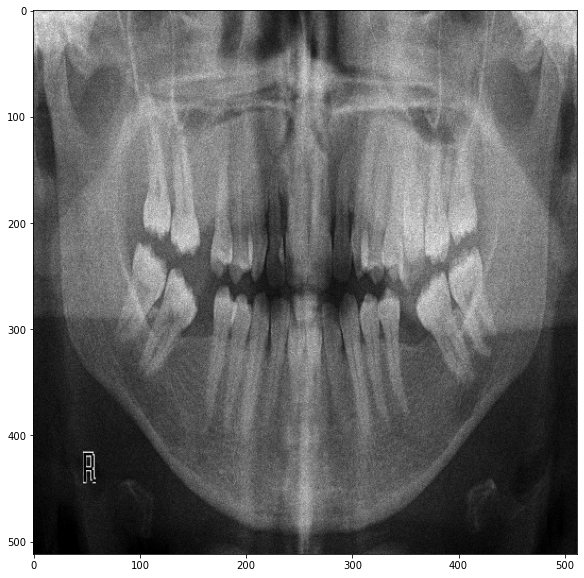

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(x_val[0])
plt.gray()

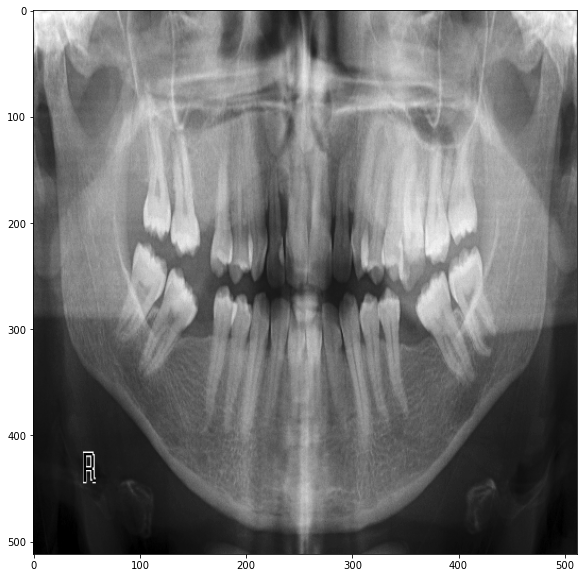

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(y_val[0])
plt.gray()